# 0. downloading the dataset

In [2]:
!kaggle datasets download -d ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes

Dataset URL: https://www.kaggle.com/datasets/ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes
License(s): CC0-1.0
 96% 128M/133M [00:01<00:00, 121MB/s]
100% 133M/133M [00:01<00:00, 113MB/s]


In [4]:
import zipfile
with zipfile.ZipFile('/content/mri-for-brain-tumor-with-bounding-boxes.zip','r') as zip_ref:
  zip_ref.extractall('/content/sample_data')

In [23]:
from torchvision import datasets, transforms
transform=transforms.Compose([
    transforms.Resize(size=(512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [56]:

train_data=datasets.ImageFolder('/content/sample_data/Train', transform=transform)
validation_dataset=datasets.ImageFolder('/content/sample_data/Val', transform=transform)


In [28]:
train_data.classes

['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

In [32]:
from collections import Counter
class_counts = Counter(train_data.targets)

# Map class indices to class names
class_names = train_data.classes
class_counts_named = {class_names[i]: class_counts[i] for i in range(len(class_names))}

print(class_counts_named)

{'Glioma': 1153, 'Meningioma': 1449, 'No Tumor': 711, 'Pituitary': 1424}


# 1. Data augmentation

In [50]:
from PIL import Image
from torchvision import datasets, transforms
import torch

class AugmentationImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, augment_class=2, num_augments=700):
        super().__init__(root, transform, target_transform)
        self.augment_class = augment_class
        self.num_augments = num_augments
        self.augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])
        self.augment_data()

    def augment_data(self):
        class_indices = [i for i, lbl in enumerate(self.targets) if lbl == self.augment_class]
        augmented_images = []

        # Convert to PIL image and augment
        for idx in class_indices:
            img, lbl = self[idx]
            if isinstance(img, torch.Tensor):
                img = transforms.ToPILImage()(img)

            # Number of augmentations per image
            num_augmentations_per_image = self.num_augments // len(class_indices)

            for _ in range(num_augmentations_per_image):
                augmented_image = self.augment_transform(img)
                augmented_images.append((augmented_image, self.augment_class))

        # Append augmented images and labels to the dataset
        self.samples.extend(augmented_images)
        self.targets.extend([self.augment_class] * len(augmented_images))


In [51]:
data_dir='/content/sample_data/Train'
train_dataset=AugmentationImageFolder(root=data_dir, transform=transform,augment_class=2,num_augments=1400)


In [53]:
class_counts = Counter(train_dataset.targets)
class_names = train_dataset.classes
class_counts_named = {class_names[i]: class_counts[i] for i in range(len(class_names))}

print(class_counts_named)

{'Glioma': 1153, 'Meningioma': 1449, 'No Tumor': 1422, 'Pituitary': 1424}


In [57]:
class_counts = Counter(validation_dataset.targets)
class_names = train_dataset.classes
class_counts_named = {class_names[i]: class_counts[i] for i in range(len(class_names))}

print(class_counts_named)

{'Glioma': 136, 'Meningioma': 140, 'No Tumor': 100, 'Pituitary': 136}


we can see that the number of images in training dataset  for each class is almost the same.

# 2. visualize

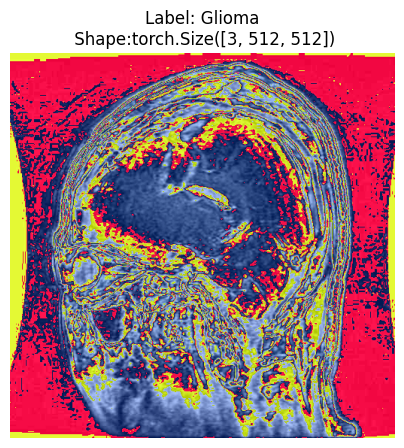

In [81]:
import matplotlib.pyplot as plt

img, lbl= train_data[1000]
image=transforms.ToPILImage()(img)
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title(f'Label: {train_dataset.classes[lbl]}\n Shape:{img.shape}')
plt.axis('off')
plt.show()


The image has 3 channels (RGB).
